In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
%matplotlib inline
plt.rcParams['figure.dpi']=150

In [38]:
import ROOT
def setup_minuit(params):
    from ctypes import c_int
    PRINT_LEVEL = 0
    UP = 1.0
    npar = len(params)
    minuit = ROOT.TMinuit(npar)
    minuit.SetFCN(nll)
    minuit.SetErrorDef(UP)
    minuit.SetPrintLevel(PRINT_LEVEL)
    
    status = c_int()
    print("{:<10s}{:>10s}{:>10s}{:>10s}{:>10s}".format('param', 'guess', 'step', 'min', 'max'))
    for ii, t in enumerate(params):
        name, guess, step, pmin, pmax = t
        print(f"{name:<10s}{guess:10.3e}{step:10.3e}{pmin:10.3e}{pmax:10.3e}")
        minuit.mnparm(ii, name, guess, step, pmin, pmax, status)
        if status.value != 0:
            raise ValueError(f"** mnparm({name}) status = {status.value}")
    return minuit

In [58]:
def perform_fit(minuit, params):
    from array import array
    from ctypes import c_int, c_double
    
    LINE = '='*79
    print(LINE)
    print('Running Minuit')
    
    # define fit control parameters
    MAXITER = 5000
    TOLERANCE = 1e-5
    args = array('d')
    args.append(MAXITER)
    args.append(TOLERANCE)
    
    swatch = ROOT.TStopwatch()
    swatch.Start()
    
    # run MIGRAD minimizer
    status = c_int()
    minuit.mnexcm('MIGRAD', args, 2, status)
    if status.value != 0:
        raise ValueError(f'** mnexcm status = {status.value}')
    print(f'real time: {swatch.RealTime():10.3f} s')
    
    # print results
    out = open('fit.txt', 'w')
    value = c_double()
    error = c_double()
    results = []
    print('{:<10s}{:>11s}{:>13s}'.format('name', 'value', 'uncertainty'))
    for ii, t in enumerate(params):
        name = t[0]
        minuit.GetParameter(ii, value, error)
        record = f'{name:10s}{value.value:11.3f}{error.value:13.3f}'
        out.write(record + '\n')
        print(record)
        results.append((value.value, error.value))
    out.close()
    print(LINE)
    return results

In [40]:
use_8TeV = True

def parse(fname):
    with open(fname) as f:
        rows = [r.split() for r in f.readlines()[1:]]
    bins = [(float(r[0]), sum(map(int, r[1:]))) for r in rows]
    bin_centers, bin_counts = map(np.array, zip(*bins))
    return bin_centers, bin_counts
    
bin_centers, bin_counts = parse('Hgg_7TeV.txt')

if use_8TeV:
    bin_counts += parse('Hgg_8TeV.txt')[1]
    
total_count = sum(bin_counts)
bin_counts = bin_counts / total_count

In [41]:
def f_s(x_i, s, m_H, w):
    return s*norm.pdf(x_i, m_H, w)

def f_b(x_i, b1, r1, b2, r2):
    return b1*np.exp(-x_i*r1) + b2*np.exp(-x_i*r2)

def a(x_i, t_s, t_b ):
    return (f_s(x_i, *t_s) + f_b(x_i, *t_b))*0.8

def nll(npar, grad, fval, xval, flag):
    t_s = [xval[i] for i in range(3)]
    t_b = [xval[i] for i in range(3,7)]
    as_ = [a(x_i, t_s, t_b) for x_i in bin_centers]
    fval[0] = sum(a_i - D_i*np.log(a_i) for D_i, a_i in zip(bin_counts, as_))

param          guess      step       min       max
s          1.000e-01 1.000e-03 0.000e+00 1.000e+00
m_H        1.250e+02 1.000e-01 1.200e+02 1.300e+02
w          4.000e+00 1.000e-02 1.000e+00 3.000e+01
b1         1.400e-01 1.000e-02 1.000e-02 1.000e+01
r1         2.000e-02 1.000e-03 1.000e-03 5.000e-01
b2         9.800e+00 1.000e-02 1.000e-02 1.000e+01
r2         6.000e-02 1.000e-03 1.000e-03 5.000e-01
Running Minuit
real time:      4.154 s
name            value  uncertainty
s               0.007        0.668
m_H           120.369        6.023
w              14.362       21.159
b1              0.122        6.129
r1              0.022        0.061
b2              9.961        7.394
r2              0.059        0.047


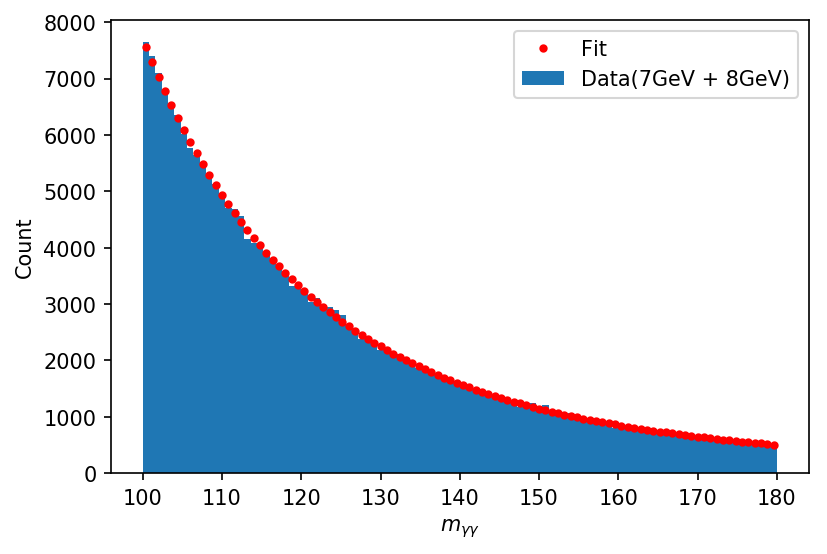

 **********
 **    1 **SET ERRDEF           1
 **********
 **********
 **    2 **SET PRINT           0
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 s            1.00000e-01  1.00000e-03    0.00000e+00  1.00000e+00
     2 m_H          1.25000e+02  1.00000e-01    1.20000e+02  1.30000e+02
     3 w            4.00000e+00  1.00000e-02    1.00000e+00  3.00000e+01
     4 b1           1.40000e-01  1.00000e-02    1.00000e-02  1.00000e+01
     5 r1           2.00000e-02  1.00000e-03    1.00000e-03  5.00000e-01
     6 b2           9.80000e+00  1.00000e-02    1.00000e-02  1.00000e+01
     7 r2           6.00000e-02  1.00000e-03    1.00000e-03  5.00000e-01
 **********
 **    3 **MIGRAD        5000       1e-05
 **********
 MACHINE ACCURACY LIMITS FURTHER IMPROVEMENT.
 MIGRAD MINIMIZATION HAS CONVERGED.
 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.
 MINUIT WARNING IN HESSE   
 ============== Negative diagonal element 2 in Error Matrix
 MINUIT 

In [80]:
params = [
    # Signal Parameters
    ('s',   0.1,    1e-3, 0,     1),
    ('m_H', 125,    1e-1, 120,   130),
    ('w',    4,     1e-2, 1,     30),
    # Background Parameters
    ('b1',   0.14,   1e-2, 1e-2,  10),
    ('r1',   2e-2,   1e-3, 1e-3,  0.5),
    ('b2',   9.8,    1e-2, 1e-2,  10),
    ('r2',   6e-2,   1e-3, 1e-3,  0.5)
          ]
minuit = setup_minuit(params)

    
results = perform_fit(minuit, params)
for ((name, *_), (val, _)) in zip(params, results):
    locals()[name] = val
 
ys = np.array([a(x, (s, m_H, w), (b1, r1, b2, r2)) for x in bin_centers])
plt.bar(bin_centers, bin_counts*total_count, label=r'Data(7GeV + 8GeV)')
plt.plot(bin_centers, ys*total_count, 'r.', label=r'Fit')
plt.xlabel(r'$m_{\gamma\gamma}$')
plt.ylabel('Count');
plt.legend()

In [77]:
def p_value(n, x_i, t_b):
    a_i = f_b(x_i, *t_b)*total_count*0.8
    n = n*total_count
    p = 1 - poisson.cdf(n, a_i)
    return p

(1, 0.001)

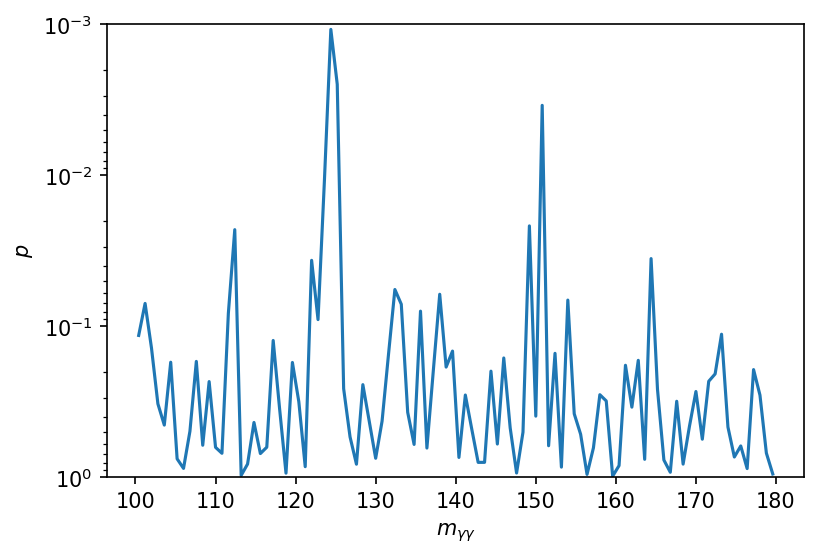

In [78]:
t_b = (b1, r1, b2, r2)
p_values = p_value(bin_counts, bin_centers, t_b)
plt.plot(bin_centers, p_values)
plt.yscale('log')
plt.xlabel(r'$m_{\gamma\gamma}$')
plt.ylabel(r'$p$')
plt.ylim((1, 1e-3))